# Smoothing Required for a Good Coarsening $R$

In [1]:
%run /Users/olivne/helmholtz/src/helmholtz/startup.ipy

In [2]:
# Fixed seed for reproducible results.
np.random.seed(2)

# Domain size.
n = 96 # 192
domain_size = n   # With meshsize h = 1.
# Scaled wave number. Fit so lam_min = 0 (integer # periods in domain).
discretization = "5-point"
#kh = 0
kh = helmholtz.analysis.ideal.find_singular_kh(discretization, n)[0]
#kh = 0.5

repetitive = True

# Test vectors.
ideal_tv = False    # Use eigenvectors or not.
# Number of test vectors.  
num_examples = 4

# Set # sweeps manually here.
num_sweeps_on_vectors = 100 # None
threshold = 0.1

# Boottstrapping parameters.
interpolation_method = "ls" # "weighted_ls" #"ls"
fit_scheme = "ridge"
weighted = True
neighborhood = "extended" #"aggregate" # "extended"
num_test_examples = 5
leeway_factor = 1.3

_LOGGER.info("kh {}".format(kh))

INFO     kh 0.5233853805513015


## Level 0

In [3]:
# Create fine-level matrix.
a = hm.linalg.helmholtz_1d_discrete_operator(kh, discretization, n)
# Use default = Kacmzarz relaxation for kh != 0.
level = hm.setup.hierarchy.create_finest_level(a,  relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)

# Initialize hierarchy to 1-level.
finest = 0
multilevel = hm.setup.hierarchy.multilevel.Multilevel.create(level)

# 'location' is an array of variable locations at all levels. Used only for interpolation neighbor determination.
# Finest-level variable ocations are assumed to be [0..n-1], i.e. a domain of size n with meshsize h = 1.
level.location = np.arange(n)

# TV and TV residual history.
x_log = []
r_log = []

### Relaxation

INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     1.269e+00                    4.470e-01    2.840
INFO     1     7.058e-01 (0.556) [0.556]    3.500e-01    2.021 (0.711)
INFO     2     4.121e-01 (0.585) [0.570]    3.045e-01    1.359 (0.672)
INFO     3     2.616e-01 (0.635) [0.591]    2.807e-01    0.938 (0.690)
INFO     4     1.830e-01 (0.699) [0.617]    2.662e-01    0.692 (0.738)
INFO     5     1.405e-01 (0.768) [0.645]    2.561e-01    0.553 (0.798)
INFO     6     1.154e-01 (0.821) [0.671]    2.484e-01    0.468 (0.846)
INFO     7     9.939e-02 (0.861) [0.695]    2.422e-01    0.414 (0.883)
INFO     8     8.840e-02 (0.889) [0.717]    2.369e-01    0.376 (0.909)
INFO     9     8.008e-02 (0.905) [0.736]    2.324e-01    0.347 (0.923)
INFO     10    7.360e-02 (0.918) [0.752]    2.283e-01    0.324 (0.935)
INFO     11    6.843e-02 (0.929) [0.767]    2.247e-01    0.306 (0.944)
INFO     12    6.421e-02 (0.938) [0.780]    2.214e-01    0.291 (0.952)
INFO 

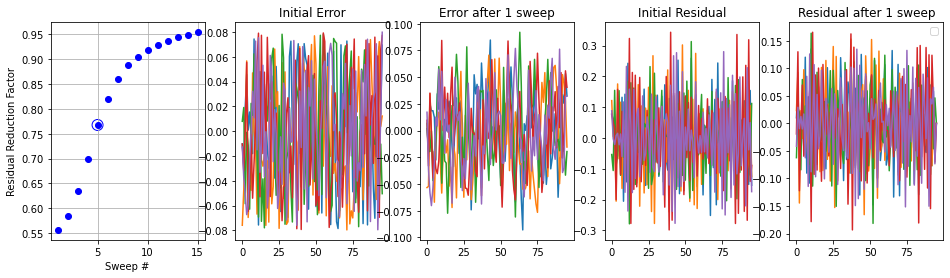

In [4]:
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    multilevel, num_levels=1, leeway_factor=1.2, slow_conv_factor=0.95)
num_sweeps = method_info["Kaczmarz"][1]
print("Relaxation slowdown starts after num_sweeps {}".format(num_sweeps))

## Level 0->1 Coarsening (4/2) vs.  $\nu$ = #TF Sweeps

In [5]:
aggregate_size = 4
num_components = 2

In [8]:
def coarsening_stats(level, num_sweeps: int, aggregate_size: int, num_components,
                     mock_cycle_num_sweeps: np.ndarray):
    """Checks coarsening based on relaxed TVs, for different number of relaxation sweeps.
    If aggregate_size is not None, forces that aggregate size for the entire domain."""
    nu_values = np.arange(1, 7)

    # Create relaxed TVs.
    x_random = hm.solve.run.random_test_matrix((level.size,), num_examples=4)
    b = np.zeros_like(x_random)
    x = hm.solve.run.run_iterative_method(
       level.operator, lambda x: level.relax(x, b), x_random, num_sweeps=num_sweeps)[0]
    r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False)
    r = r.asarray()

    # TODO: replace by local mock cycle rate.
    R = hrc.Coarsener(r).tile(level.a.shape[0] // aggregate_size)
    mock_conv = np.array([hm.setup.auto_setup.mock_cycle_conv_factor(level, R, nu) for nu in mock_cycle_num_sweeps])
    return r, s, mock_conv

def coarsening_stats_table(level, num_tv_sweeps: np.ndarray, mock_cycle_num_sweeps: np.ndarray):
    raw_info = [coarsening_stats(level, nu, aggregate_size, num_components, mock_cycle_num_sweeps) for nu in num_tv_sweeps]
    return pd.DataFrame([
        np.concatenate((s / s[0], (1 - np.cumsum(s ** 2) / sum(s ** 2)) ** 0.5, mock_conv))
        for r, s, mock_conv in raw_info], 
        index=num_tv_sweeps,
        columns=tuple("$\sigma_{}$".format(i) for i in range(1, aggregate_size + 1)) +
                tuple("$E_{}$".format(i) for i in range(1, aggregate_size + 1)) +
                tuple(r"$\bar{{\mu}}_{}$".format(nu) for nu in mock_cycle_num_sweeps)
    )

In [9]:
r_info = coarsening_stats_table(level, 2 ** np.arange(9), np.arange(1, 9))
display(r_info)

,$\sigma_1$,$\sigma_2$,$\sigma_3$,$\sigma_4$,$E_1$,$E_2$,$E_3$,$E_4$,$\bar{\mu}_1$,$\bar{\mu}_2$,$\bar{\mu}_3$,$\bar{\mu}_4$,$\bar{\mu}_5$,$\bar{\mu}_6$,$\bar{\mu}_7$,$\bar{\mu}_8$
1,1.00,0.80,0.64,0.40,0.74,0.51,0.27,0.00,0.58,0.35,0.22,0.13,0.14,0.13,0.09,0.08
2,1.00,0.87,0.45,0.26,0.71,0.37,0.18,0.00,0.64,0.33,0.16,0.15,0.18,0.17,0.16,0.13
4,1.00,0.72,0.46,0.09,0.65,0.36,0.07,0.00,0.61,0.30,0.17,0.16,0.16,0.13,0.10,0.07
8,1.00,0.57,0.12,0.03,0.51,0.11,0.02,0.00,0.60,0.32,0.18,0.13,0.14,0.13,0.09,0.06
16,1.00,0.30,0.10,0.02,0.30,0.10,0.01,0.00,0.61,0.32,0.20,0.16,0.15,0.13,0.09,0.09
32,1.00,0.49,0.05,0.00,0.45,0.05,0.00,0.00,0.61,0.32,0.19,0.14,0.15,0.13,0.09,0.07
64,1.00,0.45,0.03,0.00,0.41,0.03,0.00,0.00,0.59,0.33,0.19,0.14,0.14,0.13,0.09,0.06
128,1.00,0.58,0.07,0.01,0.50,0.06,0.01,0.00,0.59,0.33,0.19,0.14,0.15,0.13,0.09,0.06
256,1.00,0.57,0.04,0.00,0.50,0.04,0.00,0.00,0.61,0.33,0.19,0.14,0.14,0.13,0.09,0.07


Notation:
* $\sigma_i$ is the $i$th largest singular value.
* $E_i$ is the relative energy error with $i$ principal components.
* $\mu_i$ is the mock cycle rate with $i$ relaxation sweeps per cycle.

Observations:
* Relaxation starts slowing down after $\nu_* := 6$ sweeps; the mock cycle rates stabilize after $4$ sweeps, so both happen around the same time. Using say $\nu = 2 \nu_*$ sweeps on TFs is safe for obtaining a good $R$.
* The large singular values vary largely with $\nu$. Their magnitude depends on the specific composition of smooth component amplitudes in the TFs and is not important for calculating $R$. The gap is between $\sigma_2$ and $\sigma_3$; $\sigma_3$ requires many relaxation sweeps to be reduced, while the mock cycle rates are already good while it's still large. Thus, considering all cases with SVD energy error $< 30\%$, say, is reasonable for obtaining *coarsening candidates*, with the mock cycle being the *ultimate* coarsening quality criterion.

## Level 1
Loading a 6-point stencil obtained by 4/2 coarsening of level 0 from file.

In [10]:
a1 = scipy.sparse.load_npz('level_1_operator.npz')
level = hm.setup.hierarchy.create_finest_level(a1)
pd.DataFrame(a1.todense()[4:6, np.unique(a1[4:6].nonzero()[1])])

,0,1,2,3,4,5
0,0.15,-0.19,-0.03,-0.05,0.15,0.14
1,0.15,-0.16,-0.04,-0.63,-0.19,-0.16


In [11]:
r_info = coarsening_stats_table(level, 2 ** np.arange(9), np.arange(1, 9))
display(r_info)

,$\sigma_1$,$\sigma_2$,$\sigma_3$,$\sigma_4$,$E_1$,$E_2$,$E_3$,$E_4$,$\bar{\mu}_1$,$\bar{\mu}_2$,$\bar{\mu}_3$,$\bar{\mu}_4$,$\bar{\mu}_5$,$\bar{\mu}_6$,$\bar{\mu}_7$,$\bar{\mu}_8$
1,1.00,0.88,0.70,0.42,0.77,0.52,0.27,0.00,0.40,0.40,0.37,0.30,0.26,0.22,0.18,0.15
2,1.00,0.64,0.37,0.24,0.61,0.35,0.19,0.00,0.34,0.39,0.32,0.24,0.22,0.20,0.13,0.14
4,1.00,0.82,0.35,0.30,0.69,0.33,0.22,0.00,0.36,0.39,0.34,0.28,0.24,0.18,0.16,0.13
8,1.00,0.75,0.39,0.33,0.67,0.38,0.25,0.00,0.33,0.29,0.23,0.19,0.16,0.13,0.12,0.10
16,1.00,0.72,0.31,0.25,0.64,0.31,0.19,0.00,0.33,0.32,0.25,0.21,0.18,0.15,0.12,0.10
32,1.00,0.73,0.29,0.23,0.63,0.29,0.18,0.00,0.32,0.38,0.32,0.27,0.22,0.18,0.15,0.13
64,1.00,0.86,0.26,0.22,0.68,0.25,0.16,0.00,0.32,0.39,0.33,0.26,0.23,0.18,0.16,0.13
128,1.00,0.70,0.23,0.20,0.61,0.24,0.16,0.00,0.31,0.37,0.31,0.26,0.22,0.16,0.15,0.13
256,1.00,0.87,0.29,0.20,0.68,0.26,0.15,0.00,0.33,0.34,0.31,0.26,0.21,0.19,0.15,0.13


The same behaviour occurs here; it's sufficient to perform $8$ relaxations to stabilize mock cycle rates.